[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Neuvork/Engeneering-thesis/blob/master/results.ipynb)

In [1]:
! git clone https://<username>:<password>@github.com/Neuvork/Engeneeringthesis.git --single-branch --branch new_matrix_representation

Cloning into 'Engeneeringthesis'...
remote: Enumerating objects: 158, done.
remote: Counting objects: 100% (158/158), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 158 (delta 98), reused 103 (delta 47), pack-reused 0
Receiving objects: 100% (158/158), 1.57 MiB | 31.52 MiB/s, done.
Resolving deltas: 100% (98/98), done.


In [1]:
#DOPISAC CMA
#ZROBIC REKURENCYJNY ES
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import sqrtm
import time
from IPython.display import clear_output
import copy
import cupy as cp
import tensorflow_datasets as tfds
import tensorflow as tf
from Engeneeringthesis.sigmas import Sigmas_Neural_Network
from Engeneeringthesis.NeuralNetwork import Neural_Network
from Engeneeringthesis.Cma_es import CMA_ES
from Engeneeringthesis.Logs import Logs
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import mnist

In [2]:
!nvidia-smi

Sun Dec  6 16:50:13 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
mempool = cp.get_default_memory_pool()
pinned_mempool = cp.get_default_pinned_memory_pool()
def cuda_memory_clear():
    mempool.free_all_blocks()
    pinned_mempool.free_all_blocks()          

In [4]:
no_debug = 1
basic_debug_mode = 2
super_debug_mode = 3
only_interesting = 5
DEBUG_MODE = only_interesting

In [5]:
train_ds_mnist = tfds.load("mnist", split = "train", shuffle_files=True, batch_size=-1)
test_ds_mnist = tfds.load("mnist", split = "test", shuffle_files=True, batch_size=-1)

train_ds_mnist = tfds.as_numpy(train_ds_mnist)
test_ds_mnist = tfds.as_numpy(test_ds_mnist)

train_ds_mnist = {"image" : cp.array(train_ds_mnist["image"]/255., dtype=cp.float32), "label" : cp.array(train_ds_mnist["label"]) }
test_ds_mnist = {"image" : cp.array(test_ds_mnist["image"]/255., dtype=cp.float32), "label" : cp.array(test_ds_mnist["label"]) }

In [6]:
def evaluate_population(population, train_ds):
    create_input_time = 0
    preds_time = 0
    points_count_time = 0
    j  = 0
    if DEBUG_MODE % basic_debug_mode == 0:
      print("___EVALUATE_POPULATION_START")
    #scores = np.zeros(population.layers[0][1].shape[0], dtype = np.uint32)
    scores = cp.zeros(population.population_size, dtype = cp.uint32)
    for image, label in zip(cp.array(train_ds['image']), cp.array(train_ds['label'])):
        start = time.time()
        image = image.flatten()
        create_input_time += time.time() - start
        start = time.time()
        preds = population.forward(image)
        preds_time += time.time() - start
        start = time.time()
        #scores += cp.asnumpy(preds == label)
        scores += preds == label
        points_count_time += time.time() - start
        j += 1
      
    if DEBUG_MODE % basic_debug_mode == 0:
      print("___EVALUATE_POPULATION_STOP", "create_input_time: ", create_input_time, "preds_time:", preds_time,
          "points_count_time: ", points_count_time, "\n best result: ", np.max(cp.asnumpy( scores)),
          "mean socre: ", np.mean(cp.asnumpy( scores)), "min score: ", np.min(cp.asnumpy( scores))) 
    if DEBUG_MODE % only_interesting == 0:
      print("best result: ", np.max(cp.asnumpy( scores)), "mean socre: ", np.mean(cp.asnumpy( scores)), "min score: ", np.min(cp.asnumpy( scores)))

    return scores

In [7]:
!nvidia-smi

Sun Dec  6 16:50:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    28W /  70W |    447MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
def custom_plot(ax, data):
  XD = np.array([1,2,3,4,5])
  ax.plot(XD)

In [9]:
logs = Logs([('matrix','covariance'),('population','population'),('number','sigma'),
                      ('vector','isotropic'),('vector','anisotropic'),('vector','mean'),
                      ('number','best-score'),('vector','mean_act - mean_prev')])

('matrix', 'covariance')
('population', 'population')
('number', 'sigma')
('vector', 'isotropic')
('vector', 'anisotropic')
('vector', 'mean')
('number', 'best-score')
('vector', 'mean_act - mean_prev')


In [10]:
logs = Logs([('matrix','covariance'),('vector','sigma'),
                      ('vector','isotropic'),('vector','anisotropic'),('vector','mean'),
                      ('number','best-score')])

('matrix', 'covariance')
('vector', 'sigma')
('vector', 'isotropic')
('vector', 'anisotropic')
('vector', 'mean')
('number', 'best-score')


In [11]:
class Caged_CMA_ES():
  def __init__(self,population,sigma,evaluate_func, logs, number_of_cages, dimensionalities):
    self.cages = []
    self.logs = logs
    self.number_of_cages = number_of_cages
    self.population = population
    self.dimensionalities = dimensionalities
    self.dimensionality = sum(self.dimensionalities)
    self.evaluate_func = evaluate_func

    for i in range(number_of_cages):
      self.cages.append(CMA_ES(population, sigma, evaluate_func, logs, dimensionalities[i], i))

     
  def set_mean_act(self):
    ret_mean_act = []
    for i in range(number_of_cages):
      ret_mean_act.append(cp.zeros(self.dimensionalities[i], dtype = cp.float32))
    return ret_mean_act

  def update_mean(self, scores,sorted_indices,mu):
    ret_list = []
    for i in range(number_of_cages):
      ret_list.append(self.cages[i].update_mean(scores,sorted_indices,mu))
    return ret_list
    

  def set_cs(self):
    ret_list = []
    for i in range(self.number_of_cages):
      ret_list.append(0)
    return ret_list

  def find_division(self, number):
    for i in range(int(np.sqrt(number)), 2, -1):
      if number % i == 0:
        return (i , number // i)
      

  def parse_log_args(self, mean_act, scores):
    horizontal_stacks = []
    horizontal, vertical = self.find_division(self.number_of_cages)
    for i in range(vertical):
      horizontal_stacks.append(np.array(cp.asnumpy(self.cages[i*horizontal].covariance_matrix)))
      horizontal_stacks[i] = np.hstack((horizontal_stacks[i], np.zeros((self.cages[i*horizontal].covariance_matrix.shape[0], 1)) - 1))
      for j in range(1, horizontal):
        horizontal_stacks[i] = np.hstack((horizontal_stacks[i], cp.asnumpy(self.cages[i*horizontal + j].covariance_matrix)))
        horizontal_stacks[i] = np.hstack((horizontal_stacks[i], np.zeros((self.cages[i*horizontal + j].covariance_matrix.shape[0], 1)) - 1))
    
    cov = horizontal_stacks[0]
    cov = np.vstack((cov, np.zeros((1, horizontal_stacks[0].shape[1])) - 1 ))
    for i in range(1, vertical):
      cov = np.vstack((cov, horizontal_stacks[i]))
      cov = np.vstack((cov, np.zeros((1, horizontal_stacks[0].shape[1])) - 1 ))
    
    sigmas = []
    for i in range(self.number_of_cages):
      sigmas.append(self.cages[i].sigma)
    sigmas = np.array(sigmas)

    isotropic = np.array([])
    anisotropic = np.array([])
    for i in range(self.number_of_cages):
      isotropic = np.concatenate((isotropic, cp.asnumpy(self.cages[i].isotropic)))
      anisotropic = np.concatenate((anisotropic, cp.asnumpy(self.cages[i].anisotropic)))

    mean = np.array([])
    for i in range(self.number_of_cages):
      mean = np.concatenate((mean, cp.asnumpy(mean_act[i])))
    return [cov, sigmas, isotropic, anisotropic, mean, cp.max(scores)]


  def fit(self, data, mu, lam, iterations): # mu is how many best samples from population, lam is how much we generate
    for i in range(self.number_of_cages):
      self.cages[i].weights = cp.log(mu+1/2) - cp.log(cp.arange(1,mu+1))
      self.cages[i].weights = self.cages[i].weights/cp.sum(self.cages[i].weights)

    
    mu_w = 1/cp.sum(self.cages[0].weights**2)

    weights = cp.log(mu+1/2) - cp.log(cp.arange(1,mu+1))
    weights = weights/cp.sum(weights)
    problem_mu_w = 1/cp.sum(weights**2)
     
    c_1, c_sigma, d_sigma, c_covariance, c_mu = np.zeros(self.number_of_cages), np.zeros(self.number_of_cages), np.zeros(self.number_of_cages), np.zeros(self.number_of_cages), np.zeros(self.number_of_cages)

    alpha = 1.5
    for i in range(self.number_of_cages):
      c_1[i] = 2/(self.dimensionalities[i]**2)
      c_sigma[i] = (mu_w + 2)/(self.dimensionality + mu_w + 5)
      d_sigma[i] = 1 + 2*max([0,cp.sqrt((mu_w - 1)/(self.dimensionality + 1)) - 1]) + c_sigma[i] #dampening parameter could probably be hyperparameter, wiki says it is close to 1 so whatever
      c_covariance[i] = (4 + mu_w/self.dimensionalities[i])/(self.dimensionalities[i] + 4 + 2*mu_w/self.dimensionalities[i]) # c_covariance * 100 not working
      c_mu[i] = min([1-c_1[i],2*(mu_w - 2 + 1/mu_w)/(((self.dimensionalities[i]+2)**2)+mu_w)])
      
      
    
    
    mean_act = self.set_mean_act()
    mean_prev = self.set_mean_act()
    c_s = self.set_cs()

    file = open("PARAMS.txt", "w")
    file.write("c_1: " + str(c_1) + "\n \n")
    file.write("c_mu: " + str(c_mu) + "\n")
    file.write("c_sigma: " + str(c_sigma) + "\n \n")
    file.write("d_sigma: " + str(d_sigma) + "\n \n")
    file.write("c_covariance: " + str(c_covariance) + "\n")
    file.write("mu_w: " + str(mu_w) + "\n")
    file.write("problem_mu_w: " + str(problem_mu_w) + "\n")
    
    file.close()

    #body 
    for i in range(iterations):
      scores = self.evaluate_func(self.population, data)
      print(cp.max(scores))
      sorted_indices = cp.argsort(-scores)
      for j in range(len(mean_prev)):
        mean_prev[j] = mean_act[j].copy() #maybe deepcopy
      self.population.parse_to_vector()
      mean_act = self.update_mean(scores,sorted_indices,mu) #we need to be vectorized here
      self.logs.log(self.parse_log_args(mean_act, scores))
      self.logs.plot()
      for j in range(self.number_of_cages):
        self.cages[j].update_isotropic(mean_act[j],mean_prev[j],c_sigma[j],problem_mu_w)
        c_s[j] = self.cages[j].compute_cs(alpha,c_1[j],c_covariance[j])
        self.cages[j].update_anisotropic(mean_act[j],mean_prev[j],mu_w,c_covariance[j],alpha)
        self.cages[j].update_covariance_matrix(c_1[j],c_mu[j],c_s[j],scores,sorted_indices,mu,mean_prev[j])
        self.cages[j].update_sigma(c_sigma[j],d_sigma[j])

      
      Bs = []
      Ds = []
      sigmas = []
      for j in range(self.number_of_cages):
        Bs.append(self.cages[j].B_matrix)
        Ds.append(self.cages[j].D_matrix)
        sigmas.append(self.cages[j].sigma)
      self.population.caged_sample(Bs, Ds, sigmas, mean_act, lam)
      covariances = []
      sigams = []
      
      self.population.parse_from_vectors()
    return self.population

In [12]:
dimensionalities = []
for i in range(784):
  dimensionalities.append(10)
number_of_cages = 784

In [ ]:
POPULATION_SIZE = 2048
#input size do zmiany
population = Neural_Network(POPULATION_SIZE,  (28*28, 1, 1), [['linear', 10, [1.,1.]]],cage_dimensionalities=np.array(dimensionalities))

In [ ]:
classifier = Caged_CMA_ES(population, .5, evaluate_population, logs, number_of_cages,dimensionalities)

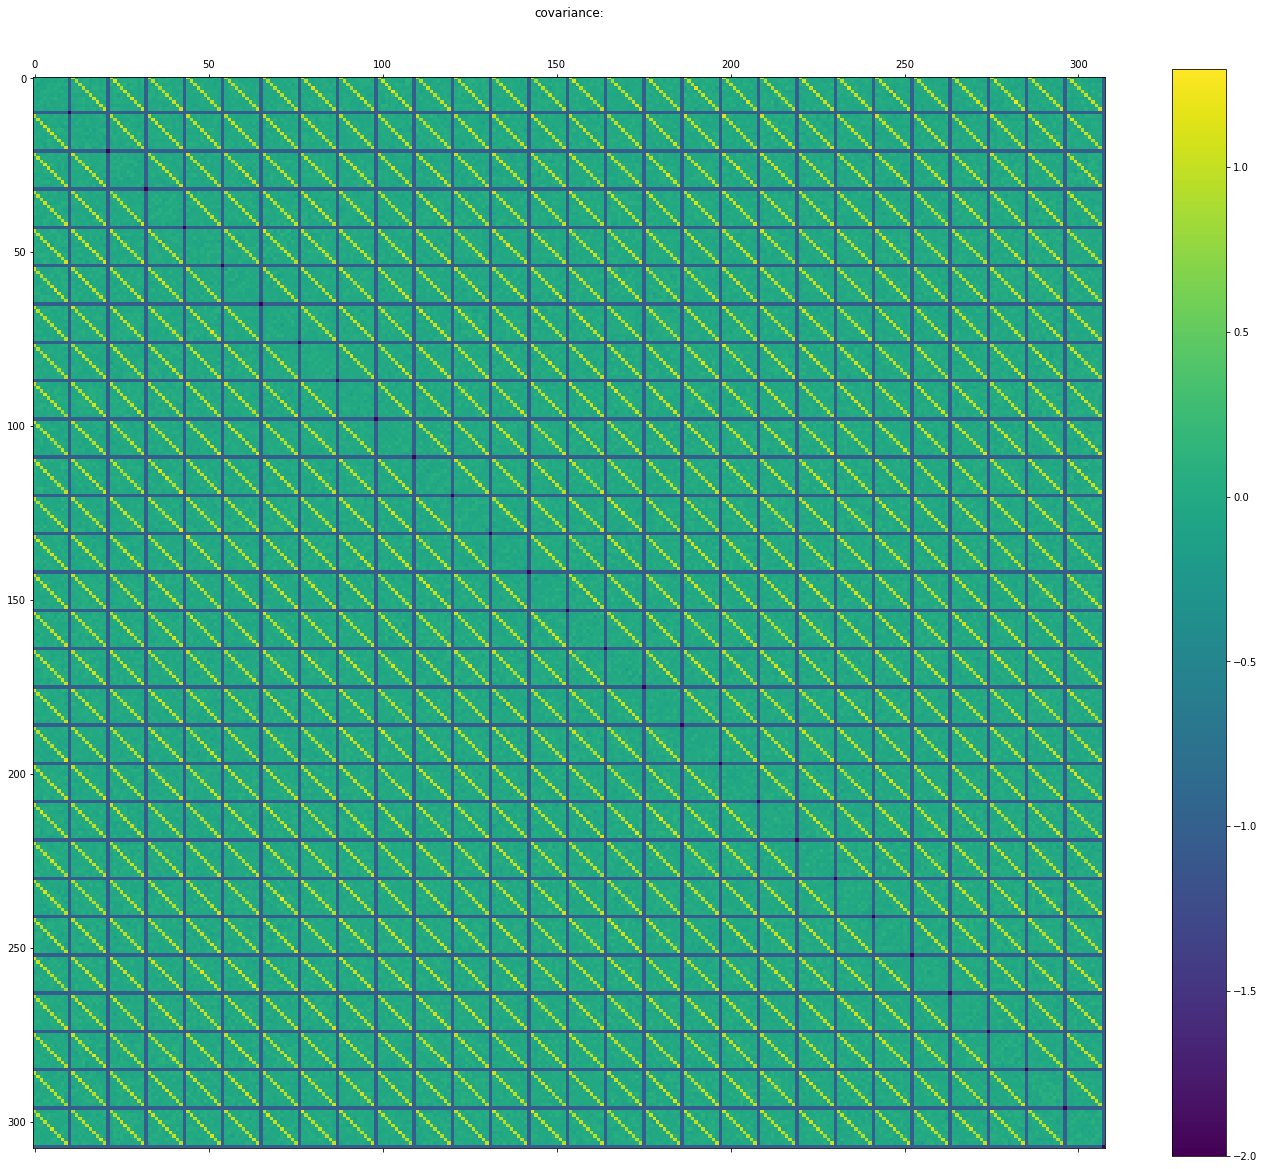

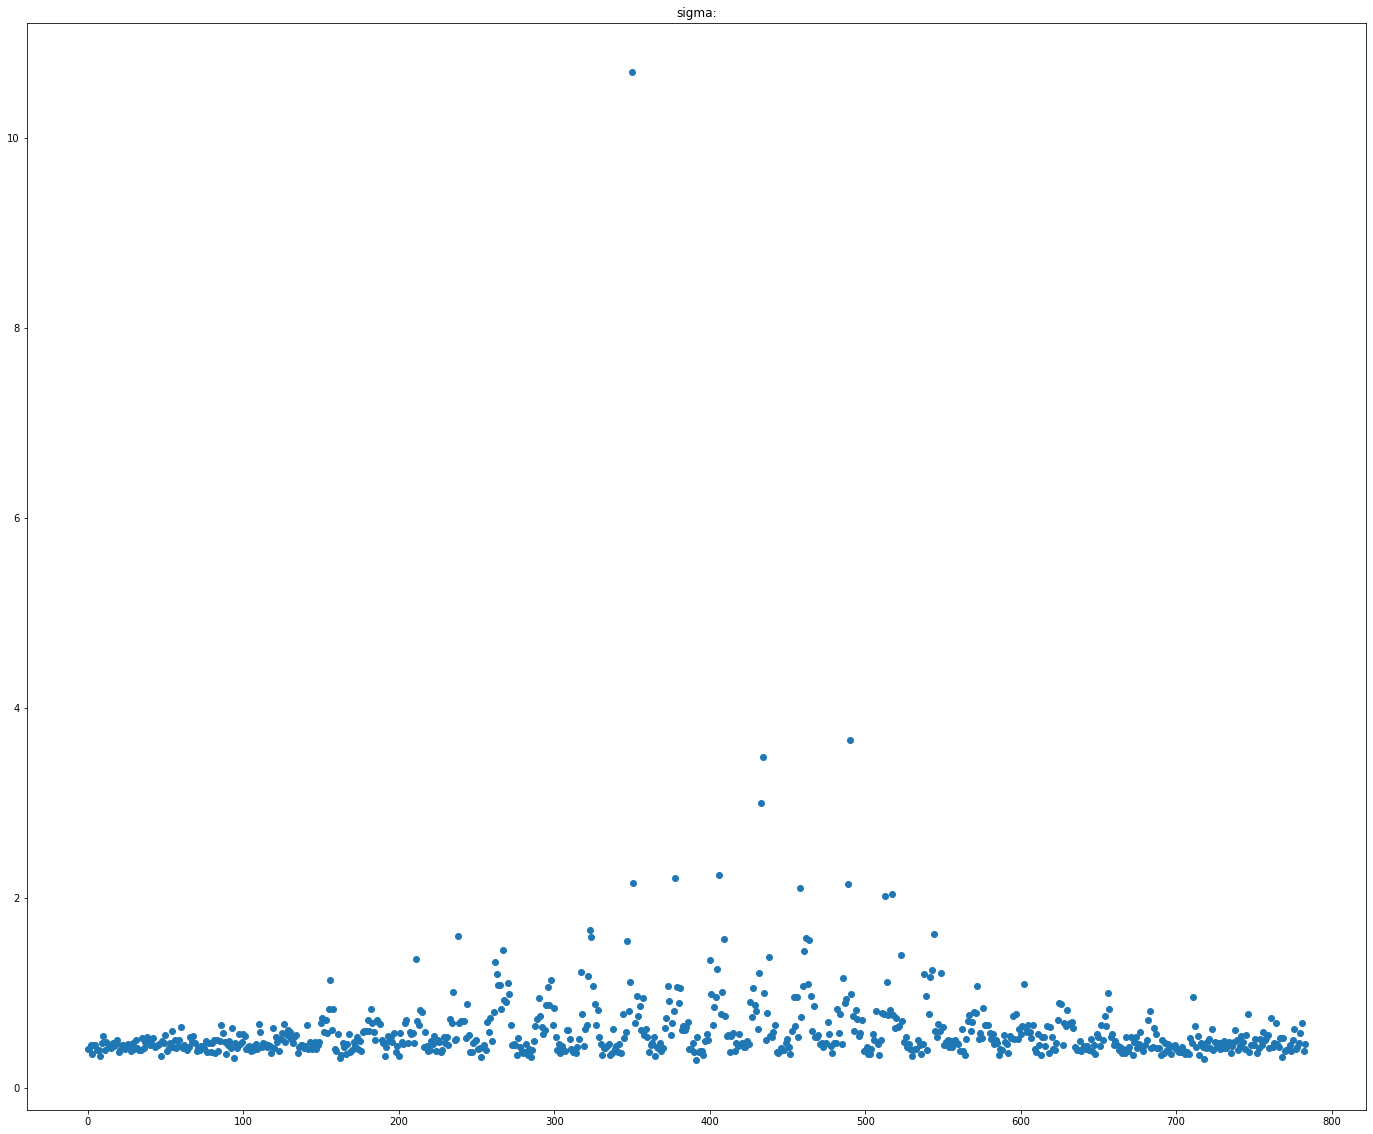

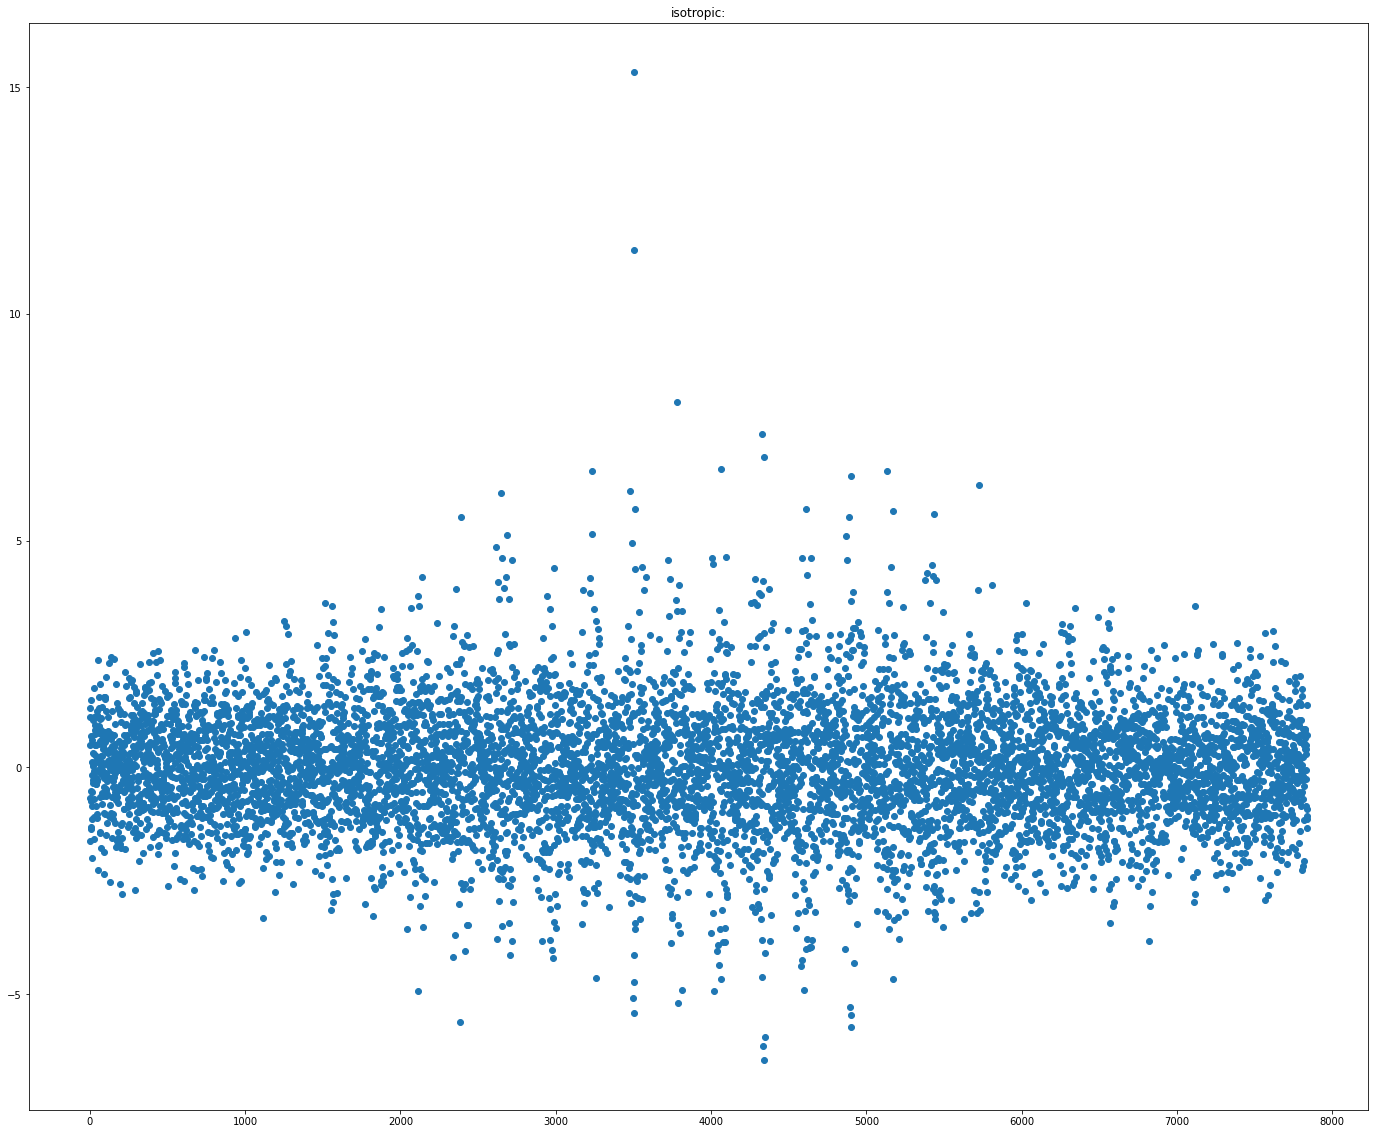

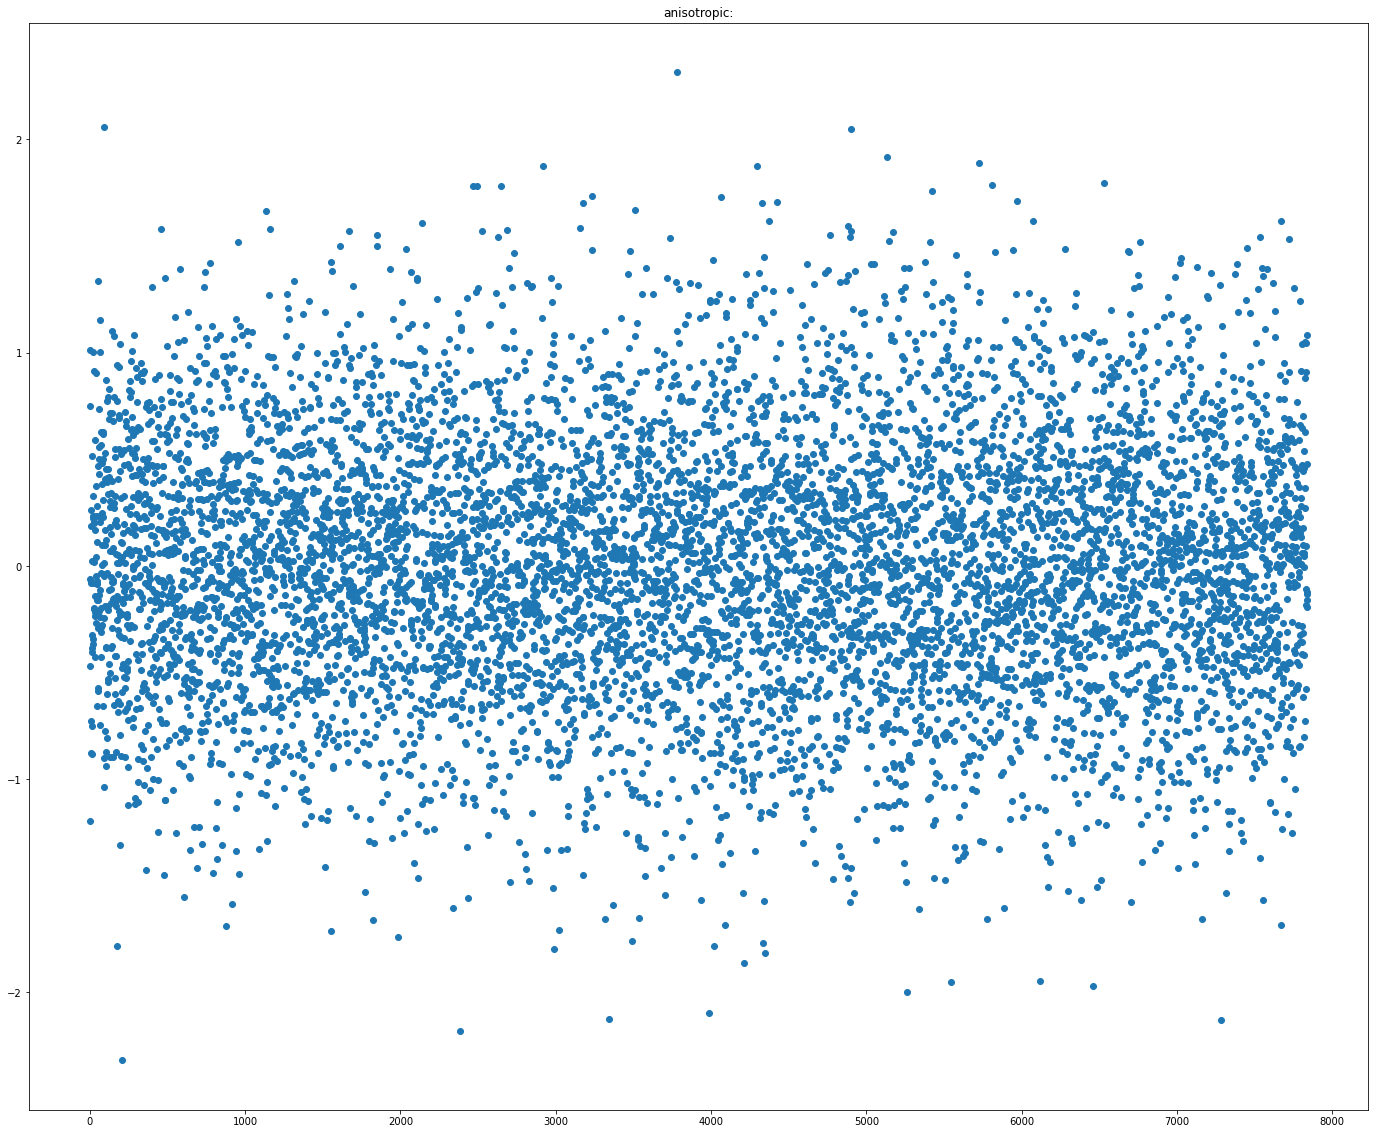

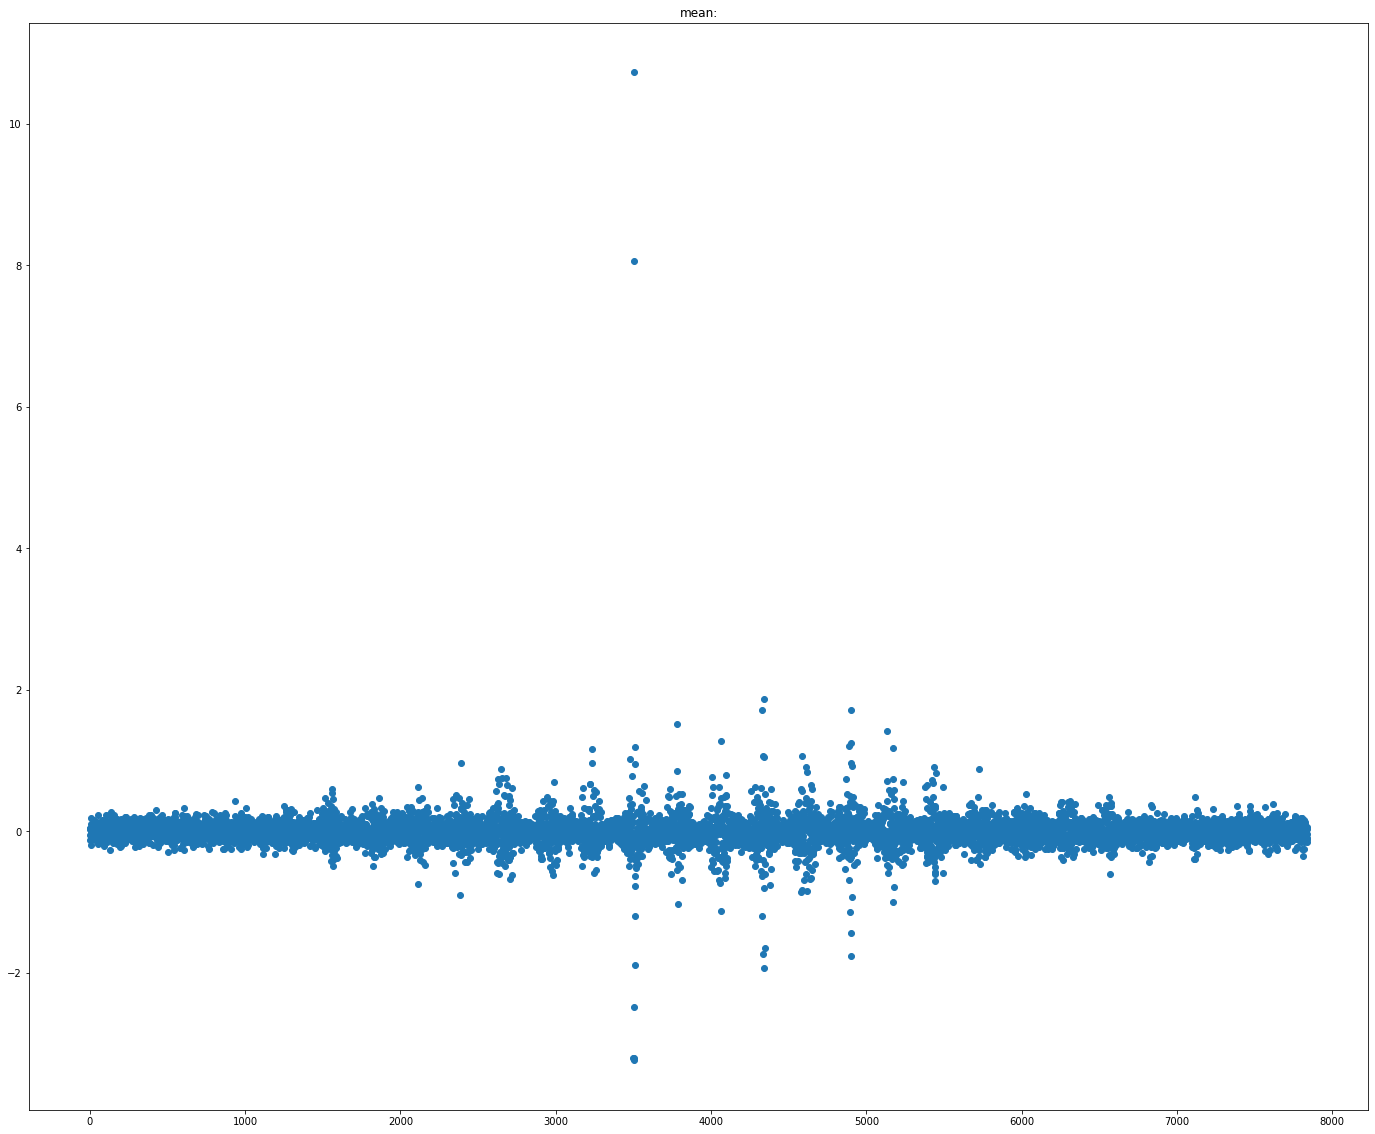

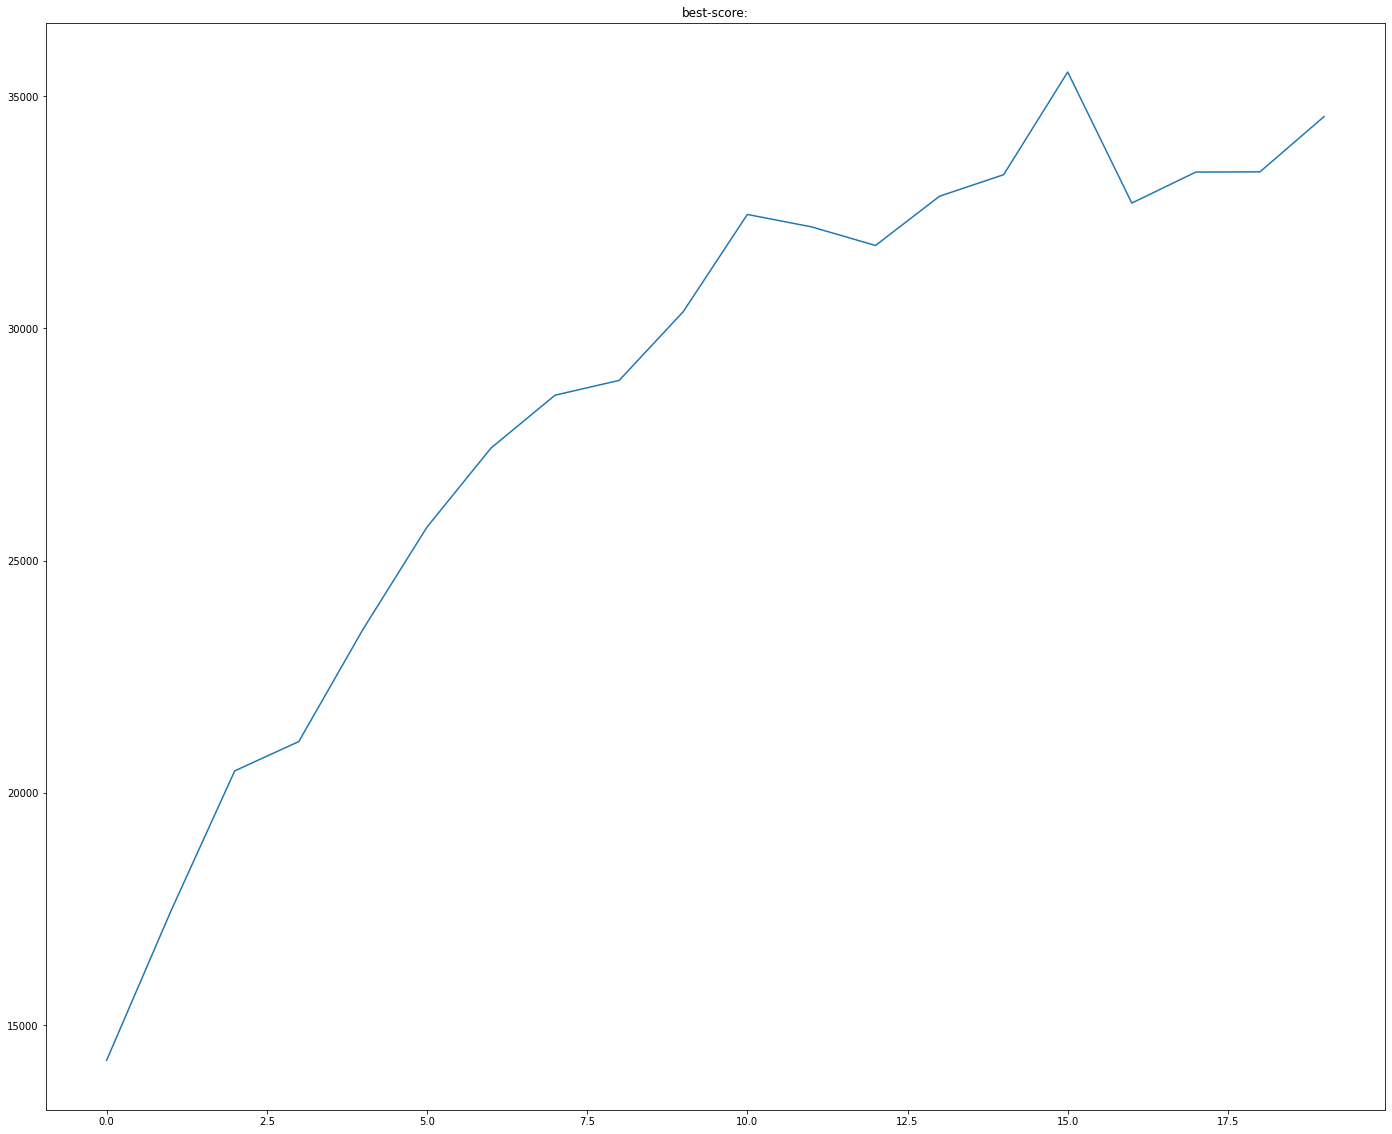

In [ ]:
classifier.fit(train_ds_mnist, POPULATION_SIZE//2, POPULATION_SIZE, 500)